In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import ODLintake
from xrsignal import xrsignal
import matplotlib.pyplot as plt
from scipy import signal
from dask.distributed import Client
import hvplot.xarray
from DAStools import tools as dt
import dask
%load_ext autoreload
%autoreload 2

In [4]:
client = Client()
client

2023-04-28 21:49:42,143 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-qkf1mwdg', purging
2023-04-28 21:49:42,144 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-heep64k_', purging
2023-04-28 21:49:42,144 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-agqz1he4', purging
2023-04-28 21:49:42,144 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-iymk8vis', purging
2023-04-28 21:49:42,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-sw9bopix', purging
2023-04-28 21:49:42,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-lb9qq9q8', purging
2023-04-28 21:49:42,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-210f1prj', purging

<Client: 'tcp://127.0.0.1:39497' processes=8 threads=32, memory=62.80 GiB>

In [3]:
fn = '/datadrive/DAS/south_DAS_latlondepth.txt'
geo = pd.read_csv(fn)
geo['distance'] = geo['index']*2.0419046878814697/1000

(-500.0, -150.0)

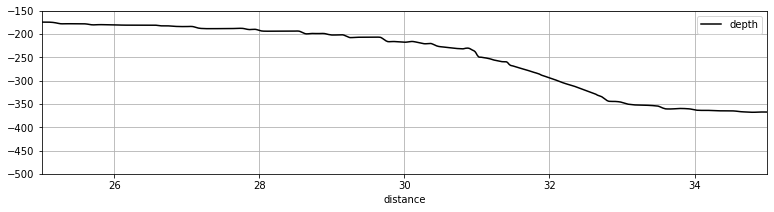

In [4]:
plt.figure(figsize=(13,3))
ax = plt.gca()
geo.plot(x='distance', y='depth', c='k', ax=ax)
plt.grid()

plt.xlim([25,35])
plt.ylim([-500,-150])

In [5]:
df_idx_30km = (geo['distance'] - 30).abs().argmin()
idx_30km = int(geo['index'][df_idx_30km])

### Try to calculate energy between 15 and 27 Hz in Time Domain
- scripts/calc_energy_TimeDomain.py

In [6]:
ds = ODLintake.open_ooi_DAS_SouthTx()

In [8]:
b,a = signal.butter(4, [0.15, 0.27], btype='bandpass')
ds_filt = da_filt = xrsignal.filtfilt(ds['RawData'], b=b, a=a, dim='time')

In [15]:
DAS_energy = (ds_filt**2).rolling(time=3000).construct(window_dim='time_window', stride=3000).mean('time_window')

### Build Chunkwise method...
- I think rolling won't work

In [3]:
da = ODLintake.open_ooi_DAS_SouthTx()['RawData']
da_slice = da.isel({'distance':slice(6000,9000), 'time':slice(0,3000*10)})

In [4]:
da_energy = dt.energy_TimeDomain(da_slice, time_dim='time')

In [5]:
da_energy.compute()

<xarray.DataArray 'energy in time dimension' (distance: 3000, time: 10)>
array([[-53763178263,  33837536630,  53334639902, ..., -31116266593,
        -11231093535,  92956861111],
       [ 11913100147, -31877130595, 201280731637, ..., -22646479559,
        -29227367330,   3949227162],
       [-59142123472,  23870952348,  29144632928, ...,  34651102503,
         15941810810,  38671764268],
       ...,
       [ 50458567161,  32747488341, -13046401280, ...,  29600016181,
        162248048777, -80968746987],
       [ 65453464553, -58180324901,  27495920807, ...,  57023298102,
        -80242104018,   7684977334],
       [ 13423721676,  55914215228,  -8111848326, ..., -38409611358,
        -57946043485, -43849374310]])
Dimensions without coordinates: distance, time

### Look at results

In [3]:
time_coord = pd.to_datetime(ODLintake.open_ooi_DAS_SouthTx()['RawDataTime'][::3000], unit='us')

In [4]:
fn = '/datadrive/DAS/DAS_energy_15-28.nc'
da = xr.open_dataarray(fn)
da = da.assign_coords({'time':time_coord, 'distance':np.arange(0,47500*2/1000,2/1000)})

In [5]:
(10*np.log10(da)).hvplot.image(x='time', y='distance', rasterize=True, cmap='inferno', ylabel='distance [km]')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


:DynamicMap   []
   :Image   [time,distance]   (energy in time dimension)